# Sign Language Recognition Model Training (Colab)

In this notebook, I am training an LSTM model for real-time sign language recognition using MediaPipe Holistic keypoints. I load my saved keypoints from Google Drive, explore the dataset, train the model, evaluate it, and save the final model and label map.


## Installing All The Required Packages

In [1]:
!pip install --upgrade tensorflow opencv-python mediapipe scikit-learn matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.6 MB/s eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take

## Fixing The Dependency Issues

In [1]:
!pip  install --upgrade "numpy>=2.0,<2.3" "protobuf>=4.25.3,<5.0"

  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 135.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.1 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.19.1 which is incompatible.


## Installing tqdm Package To Show The Progress Bar

In [1]:
!pip install tqdm -q

## Loading the Required Packages.

In [2]:
# Setup: imports and Google Drive mount

import os
import pickle
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    multilabel_confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    TensorBoard,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


## Mounting The Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration

Here I set all paths, feature dimensions, and training hyperparameters that I use throughout the notebook.

In [4]:
# Base path in my Google Drive for this project
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Communicare'

# Data and output directories
DATA_PATH = os.path.join(BASE_PATH, 'MP_Data')
MODELS_DIR = os.path.join(BASE_PATH, 'models')
LOGS_DIR = os.path.join(BASE_PATH, 'Logs')

# Whether I use face landmarks or not
USE_FACE_FEATURES = False  # I can switch this to True if I captured face landmarks

# Feature dimensions:
# - With face: 1662 (Pose 132 + Face 1404 + Left Hand 63 + Right Hand 63)
# - Without face: 258 (Pose 132 + Left Hand 63 + Right Hand 63)
NUM_KEYPOINTS = 1662 if USE_FACE_FEATURES else 258

# Sequence length (number of frames per sequence)
SEQUENCE_LENGTH = 30  # 30 frames ≈ 1 second at 30 FPS

# Training hyperparameters
EPOCHS = 2000
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
TRAIN_SPLIT = 0.70
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

# Defining Output Folders also making sure it exists setting up to True
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)



In [5]:
print("Sign Language Recognition - Model Training")
print("Configuration:")
print(f"  USE_FACE_FEATURES : {USE_FACE_FEATURES}")
print(f"  NUM_KEYPOINTS     : {NUM_KEYPOINTS}")
print(f"  SEQUENCE_LENGTH   : {SEQUENCE_LENGTH}")
print(f"  DATA_PATH         : {DATA_PATH}")


Sign Language Recognition - Model Training
Configuration:
  USE_FACE_FEATURES : False
  NUM_KEYPOINTS     : 258
  SEQUENCE_LENGTH   : 30
  DATA_PATH         : /content/drive/My Drive/Colab Notebooks/Communicare/MP_Data


## Dataset structure helper Function

Here I scan my dataset folders and figure out how many frames each class has.


In [6]:
def analyze_dataset_structure(data_path):
    """
    I inspect my dataset structure and detect the number of frames
    (sequence length) for each class.

    Expected layout:
        data_path/
            CLASS_NAME/
                0/
                    0.npy, 1.npy, ...
                1/
                    ...
    """
    if not os.path.exists(data_path):
        print(f"Warning: Data path not found: {data_path}")
        return {}

    class_lengths = {}
    class_dirs = [
        d for d in os.listdir(data_path)
        if os.path.isdir(os.path.join(data_path, d))
    ]

    for class_name in sorted(class_dirs):
        class_path = os.path.join(data_path, class_name)

        # Each subfolder number (0, 1, 2, ...) is one sequence
        sequence_dirs = [
            d for d in os.listdir(class_path)
            if os.path.isdir(os.path.join(class_path, d)) and d.isdigit()
        ]

        if sequence_dirs:
            # I just check the first sequence for this class to get frame count
            first_seq = sorted(sequence_dirs, key=int)[0]
            first_seq_path = os.path.join(class_path, first_seq)

            frame_files = sorted(
                [f for f in os.listdir(first_seq_path) if f.endswith('.npy')],
                key=lambda x: int(x.split('.')[0])
            )
            class_lengths[class_name] = len(frame_files)

    return class_lengths


## Single sequence loader

Here I load one sequence folder and turn it into a fixed-size array that my LSTM can use.


In [7]:
def load_sequence_data(sequence_dir, num_keypoints, sequence_length, use_face_features):
    """
    I am loading one sequence (one folder of frames) and return a fixed-length
    array of shape (sequence_length, num_keypoints).

    I handle both:
      - full frame vectors with face landmarks
      - shorter vectors without face landmarks
    and I map pose and hands correctly in both cases.
    """
    # I pre-allocate the full window to keep this fast
    sequence_window = np.zeros((sequence_length, num_keypoints), dtype=np.float32)

    for frame_idx in range(sequence_length):
        frame_file = os.path.join(sequence_dir, f"{frame_idx}.npy")

        try:
            frame_data = np.load(frame_file, allow_pickle=False)

            # Exact match: simple case
            if len(frame_data) == num_keypoints:
                sequence_window[frame_idx] = frame_data

            # Saved with face, but I choose to ignore face features
            elif len(frame_data) == 1662 and not use_face_features:
                sequence_window[frame_idx, 0:132] = frame_data[0:132]         # Pose
                sequence_window[frame_idx, 132:195] = frame_data[1536:1599]   # Left hand
                sequence_window[frame_idx, 195:258] = frame_data[1599:1662]   # Right hand

            # Saved without face, but I want a tensor that can hold face features
            elif len(frame_data) == 258 and use_face_features:
                sequence_window[frame_idx, 0:132] = frame_data[0:132]         # Pose
                # Face block stays as zeros
                sequence_window[frame_idx, 1536:1599] = frame_data[132:195]   # Left hand
                sequence_window[frame_idx, 1599:1662] = frame_data[195:258]   # Right hand

            # Fallback if lengths do not match exactly
            else:
                if len(frame_data) > num_keypoints:
                    sequence_window[frame_idx] = frame_data[:num_keypoints]
                else:
                    sequence_window[frame_idx, :len(frame_data)] = frame_data

        except (FileNotFoundError, OSError, ValueError):
            # If a frame is missing or corrupted, I keep the zero vector for that frame
            continue
        except Exception as e:
            print(f"Warning: Error loading frame {frame_idx} from {sequence_dir}: {e}")
            continue

    return sequence_window


## Load all sequences

Now I load all sequences from all classes, using parallel workers to speed it up works good on CPU's.

In [8]:
def load_all_sequences(
    data_path,
    target_sequence_length=30,
    num_keypoints=258,
    use_face_features=False,
    max_workers=None
):
    """
    I load all sequences in my dataset into memory.

    Steps:
      - find all classes
      - keep only classes that match the target sequence length
      - collect all sequence folders for those classes
      - load each sequence in parallel
      - return X (features), y (labels), and the list of class names
    """
    if not os.path.exists(data_path):
        print(f"Error: Data path not found: {data_path}")
        return None, None, []

    # First I inspect the structure and get sequence lengths per class
    class_lengths = analyze_dataset_structure(data_path)

    # I only keep classes that have the correct number of frames
    gesture_classes = [
        cls for cls, length in class_lengths.items()
        if length == target_sequence_length
    ]

    print("\nDataset Analysis")
    print(f"  Total classes found: {len(class_lengths)}")
    print(f"  Classes with {target_sequence_length} frames : {len(gesture_classes)}")

    if not gesture_classes:
        print("  No classes meet the target sequence length requirement.")
        return None, None, []

    # Map class names to integer labels
    label_to_index = {
        label: idx for idx, label in enumerate(sorted(gesture_classes))
    }

    sequence_paths = []
    sequence_labels = []

    # I walk through each class and collect all sequence directories
    for gesture_class in sorted(gesture_classes):
        class_path = os.path.join(data_path, gesture_class)
        sequence_dirs = sorted(
            [
                os.path.join(class_path, d)
                for d in os.listdir(class_path)
                if os.path.isdir(os.path.join(class_path, d)) and d.isdigit()
            ],
            key=lambda x: int(os.path.basename(x))
        )
        for seq_dir in sequence_dirs:
            sequence_paths.append(seq_dir)
            sequence_labels.append(label_to_index[gesture_class])

    print(f"  Total sequences to load: {len(sequence_paths)}")

    # Decide how many parallel workers to use
    if max_workers is None:
        max_workers = min(multiprocessing.cpu_count() * 2, 16)

    print(f"  Using {max_workers} parallel workers for loading sequences...")

    def load_wrapper(seq_path):
        return load_sequence_data(
            seq_path,
            num_keypoints=num_keypoints,
            sequence_length=target_sequence_length,
            use_face_features=use_face_features
        )

    # I load all sequences in parallel with a progress bar
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        loaded_sequences = list(
            tqdm(
                executor.map(load_wrapper, sequence_paths),
                total=len(sequence_paths),
                desc="Loading sequences",
                unit="seq"
            )
        )

    valid_sequences = []
    valid_labels = []

    # I only keep sequences that have the exact target length
    for seq, label in zip(loaded_sequences, sequence_labels):
        if seq is not None and seq.shape[0] == target_sequence_length:
            valid_sequences.append(seq)
            valid_labels.append(label)

    if not valid_sequences:
        print("\n  No valid sequences were loaded.")
        return None, None, []

    X = np.array(valid_sequences, dtype=np.float32)
    y = np.array(valid_labels, dtype=np.int32)

    print("\nLoading Complete")
    print(f"  Successfully loaded sequences : {len(X)}")
    print(f"  Sequence tensor shape: {X.shape}")
    print(f"  Number of gesture classes: {len(gesture_classes)}")

    return X, y, sorted(gesture_classes)


## Visualizing my dataset

Now that I can load the data, I want to see how balanced my classes are and how I am splitting my data.


In [9]:
def visualize_class_distribution(labels, class_names, save_path=None):
    """
    Visualizing how many sequences I have for each gesture class.

    Input:
        labels: 1D array-like
            Integer class indices for each sequence, shape (N,).
        class_names: list[str]
            List of class names where class_names[i] is the name for label i.
        save_path: str or None (default: None)
            If provided, the bar chart is saved to this file path
            (for example: 'logs/class_distribution.png'). If None, it is only shown.

    Output:
        None.
            This function displays a bar chart of the class counts and
            optionally saves it as an image file.
    """
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(unique_labels)), counts, color='steelblue', alpha=0.7)
    plt.xlabel('Gesture Class', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Sequences', fontsize=12, fontweight='bold')
    plt.title('Dataset Class Distribution', fontsize=14, fontweight='bold')
    plt.xticks(
        range(len(unique_labels)),
        [class_names[i] for i in unique_labels],
        rotation=45,
        ha='right'
    )
    plt.grid(axis='y', alpha=0.3)

    # Showing the counts on top of each bar
    for bar, count in zip(bars, counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(counts) * 0.01,
            f'{count}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



def visualize_data_split(train_size, val_size, test_size, save_path=None):
    """
    Visualizing how many samples are in the train, validation, and test splits.

    Input:
        train_size: int
            Number of training samples (or sequences).
        val_size: int
            Number of validation samples.
        test_size: int
            Number of test samples.
        save_path: str or None (default: None)
            If provided, the bar chart is saved to this file path
            (for example: 'logs/data_split.png'). If None, it is only shown.

    Output:
        None.
            This function displays a bar chart with counts and percentages
            for each split and optionally saves it as an image file.
    """
    categories = ['Training', 'Validation', 'Test']
    sizes = [train_size, val_size, test_size]
    total = sum(sizes)
    percentages = [s / total * 100 for s in sizes]
    colors = ['#2ecc71', '#f39c12', '#e74c3c']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, sizes, color=colors, alpha=0.7)

    plt.xlabel('Data Split Category', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Sequences', fontsize=12, fontweight='bold')
    plt.title('Data Split Distribution', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)

    # Showing both count and percentage on top of each bar
    for bar, size, pct in zip(bars, sizes, percentages):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(sizes) * 0.01,
            f'{int(size):,} ({pct:.1f}%)',
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


## Watching my training process

I also want to see how the loss, accuracy, and learning rate change over time so I can spot overfitting or training issues.


In [10]:
def visualize_training_history(history, save_path=None):
    """
    I plot loss, accuracy, learning rate, and the gap between train and val loss.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Loss Over Epochs', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Accuracy curves
    acc_key = 'categorical_accuracy' if 'categorical_accuracy' in history.history else 'accuracy'
    if acc_key in history.history:
        axes[0, 1].plot(history.history[acc_key], label=f'Train {acc_key}', linewidth=2)
        if f'val_{acc_key}' in history.history:
            axes[0, 1].plot(history.history[f'val_{acc_key}'], label=f'Val {acc_key}', linewidth=2)
        axes[0, 1].set_title('Accuracy Over Epochs', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)

    # Learning rate schedule
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], linewidth=2, color='purple')
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(alpha=0.3)

    # Train vs validation loss difference
    if 'loss' in history.history and 'val_loss' in history.history:
        loss_diff = np.array(history.history['loss']) - np.array(history.history['val_loss'])
        axes[1, 1].plot(loss_diff, linewidth=2, color='red', alpha=0.7)
        axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[1, 1].set_title('Train - Val Loss', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss Difference')
        axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


## Understanding my model’s predictions

Once the model is trained, I want to see where it gets confused and how confident it usually is.


In [11]:
def visualize_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """
    I plot the confusion matrix so I can see which classes the model mixes up.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'}
    )
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def visualize_prediction_confidence(y_pred_proba, class_names, save_path=None):
    """
    I look at the distribution of maximum prediction confidence across test samples.
    """
    max_confidences = np.max(y_pred_proba, axis=1)

    plt.figure(figsize=(10, 6))
    plt.hist(
        max_confidences,
        bins=50,
        color='steelblue',
        alpha=0.7,
        edgecolor='black'
    )
    plt.xlabel('Maximum Prediction Confidence', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    plt.axvline(
        x=np.mean(max_confidences),
        color='red',
        linestyle='--',
        linewidth=2,
        label=f'Mean: {np.mean(max_confidences):.3f}'
    )
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


## Building my LSTM model

Here I define the LSTM-based model that I use to recognize sign language sequences.


In [12]:
def build_lstm_model(input_shape, num_classes, learning_rate=0.0001):
    """
    I build and compile a stacked LSTM model for my sign language data.
    """
    model = Sequential([
        # First LSTM layer to capture short-term patterns
        LSTM(64, return_sequences=True, activation='relu', input_shape=input_shape),
        Dropout(0.2),

        # Second LSTM layer for deeper temporal features
        LSTM(128, return_sequences=True, activation='relu'),
        Dropout(0.2),

        # Third LSTM layer to aggregate the sequence into one vector
        LSTM(64, return_sequences=False, activation='relu'),
        Dropout(0.2),

        # Fully connected classifier head
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)

    if num_classes == 2:
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )
    else:
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy']
        )

    return model


## Load dataset and visualize

Now I load all sequences from my dataset and quickly visualize how many samples I have per class.

Loading Dataset

Dataset Analysis
  Total classes found: 16
  Classes with 30 frames : 16
  Total sequences to load: 976
  Using 16 parallel workers for loading sequences...


Loading sequences: 100%|██████████| 976/976 [00:32<00:00, 30.47seq/s]



Loading Complete
  Successfully loaded sequences : 976
  Sequence tensor shape: (976, 30, 258)
  Number of gesture classes: 16
Data Visualization


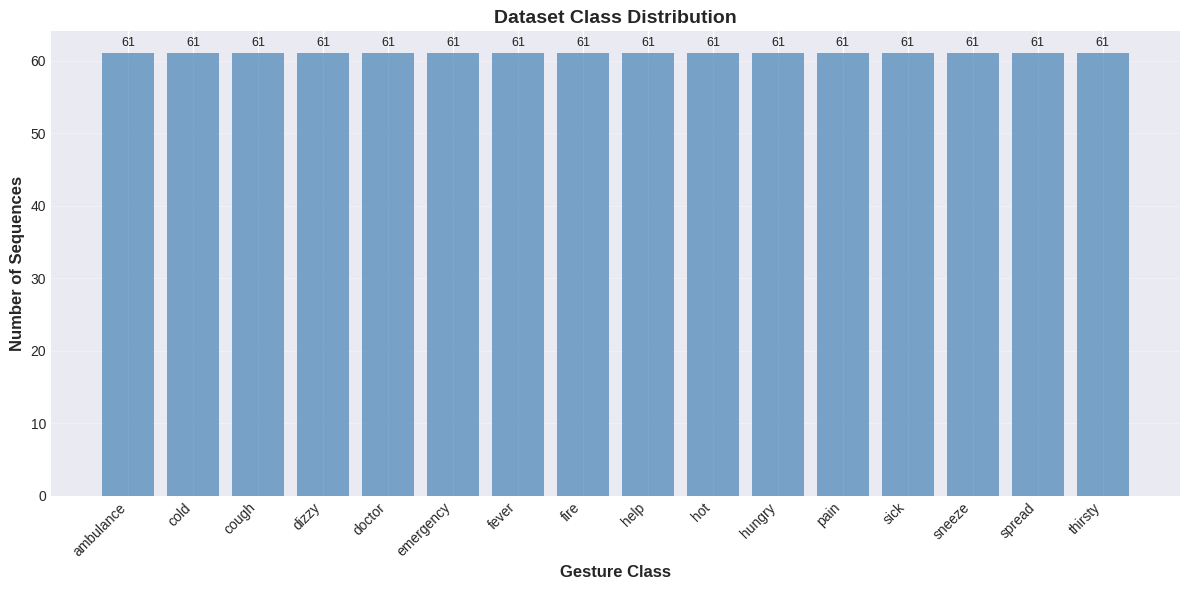

In [14]:
# I now load all my preprocessed sequences and labels from disk.
print("Loading Dataset")

X, y, gesture_classes = load_all_sequences(
    DATA_PATH,
    target_sequence_length=SEQUENCE_LENGTH,  # Giving a fixed sequence length
    num_keypoints=NUM_KEYPOINTS,            # number of features per frame
    use_face_features=USE_FACE_FEATURES     # Has face landmarks or not
)

# I add a safety check so I don't continue with an empty or invalid dataset.
if X is None or len(X) == 0:
    print("Error: No data loaded. Please check DATA_PATH and dataset structure.")
    raise ValueError("No data loaded. Check DATA_PATH configuration.")

# If loading worked, I immediately take a quick look at class balance.
print("Data Visualization")

visualize_class_distribution(
    y,
    class_names=gesture_classes,
    save_path=os.path.join(LOGS_DIR, 'class_distribution.png')
)

The dataset is perfectly balanced, with each gesture class (like "ambulance", "cold", "doctor", etc.) having exactly 61 sequences, ensuring no class imbalance bias in training

## Train/validation/test split

Here I split my data into train, validation, and test sets and plot the split.


Training set   : 683 samples (70.0%)
Validation set : 146 samples (15.0%)
Test set       : 147 samples (15.1%)


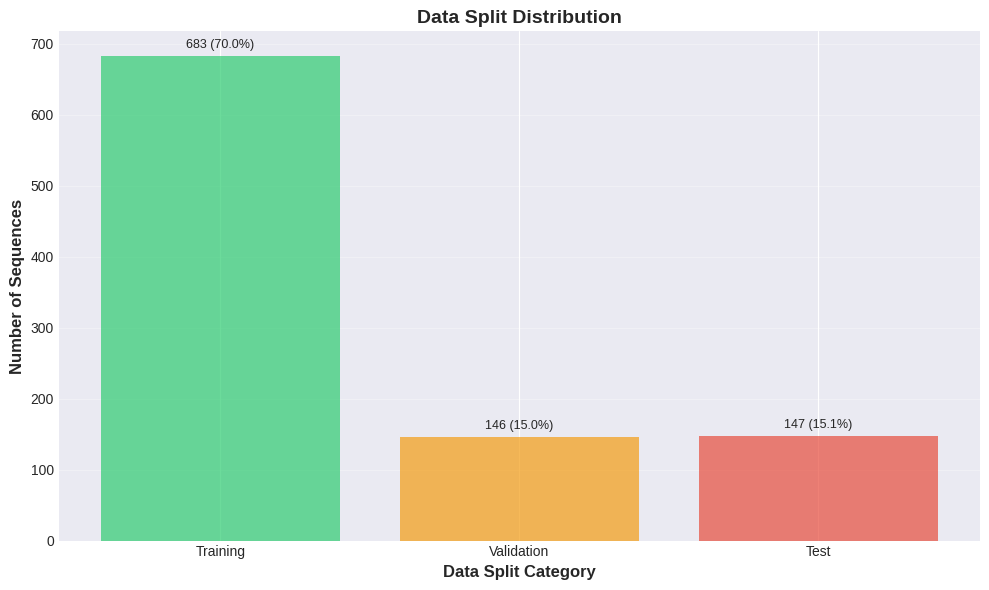

In [15]:
# Converting integer labels into one‑hot encoded vectors for training.
y_categorical = to_categorical(y, num_classes=len(gesture_classes))

# First split: train vs (val + test)
X_train, X_temp, y_train, y_temp, y_train_int, y_temp_int = train_test_split(
    X,                # full feature tensor (sequences)
    y_categorical,    # one-hot labels
    y,                # integer labels
    test_size=(VAL_SPLIT + TEST_SPLIT),  # 0.30 here (0.15 + 0.15)
    random_state=42,  # fixed seed so the split is reproducible
    stratify=y        # keeps class distribution balanced across splits
)

# Second split: validation vs test (each half of the remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=(TEST_SPLIT / (VAL_SPLIT + TEST_SPLIT)),  # 0.15 / 0.30 = 0.5
    random_state=42
)

# Displaying how many samples and percentage for each split.
print(f"Training set   : {len(X_train)} samples ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validation set : {len(X_val)} samples ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Test set       : {len(X_test)} samples ({len(X_test) / len(X) * 100:.1f}%)")

# Pie Chart to Visualize the Split.
visualize_data_split(
    train_size=len(X_train),
    val_size=len(X_val),
    test_size=len(X_test),
    save_path=os.path.join(LOGS_DIR, 'data_split.png')
)


The dataset is split into 70% training, 15% validation, and about 15% test data, giving enough samples for learning while keeping robust evaluation sets

## Build model and configure callbacks

Building the LSTM model and set up callbacks for TensorBoard, early stopping, model checkpoints, and learning rate scheduling.

In [16]:
# Defining the input shape as (sequence_length, num_keypoints).
input_shape = (SEQUENCE_LENGTH, NUM_KEYPOINTS)

# Building the LSTM model.
model = build_lstm_model(
    input_shape=input_shape,
    num_classes=len(gesture_classes),
    learning_rate=LEARNING_RATE
)
model.summary()

# Logging the training runs to TensorBoard.
tensorboard_log_dir = os.path.join(LOGS_DIR, 'tensorboard')

# Defining callbacks that help me control and monitor training.
callbacks = [
    TensorBoard(log_dir=tensorboard_log_dir),

    EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        os.path.join(MODELS_DIR, 'sign_lstm_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-5,
        verbose=1
    )
]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,680 (928.44 KB)

 Trainable params: 237,680 (928.44 KB)

 Non-trainable params: 0 (0.00 B)

## Train model

Now I train my model on the training data and monitor validation performance.


In [17]:
print("Training Model")
print(f"Epochs       : {EPOCHS} (with early stopping)")
print(f"Batch size   : {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Classes      : {gesture_classes}")

# Fitting the model on the training data and validate on the validation set.
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)


Training Model
Epochs       : 2000 (with early stopping)
Batch size   : 32
Learning rate: 0.0001
Classes      : ['ambulance', 'cold', 'cough', 'dizzy', 'doctor', 'emergency', 'fever', 'fire', 'help', 'hot', 'hungry', 'pain', 'sick', 'sneeze', 'spread', 'thirsty']
Epoch 1/2000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - categorical_accuracy: 0.0510 - loss: 2.7736
Epoch 1: val_loss improved from inf to 2.75762, saving model to /content/drive/My Drive/Colab Notebooks/Communicare/models/sign_lstm_best.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 574ms/step - categorical_accuracy: 0.0517 - loss: 2.7735 - val_categorical_accuracy: 0.0890 - val_loss: 2.7576 - learning_rate: 1.0000e-04
Epoch 2/2000
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.0992 - loss: 2.7593
Epoch 2: val_loss improved from 2.75762 to 2.71675, saving model to /content/drive/My Drive/Colab Notebooks/Communicare/models/sign_lstm_best.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.0985 - los

## Training curves

Plotting how the loss, accuracy, and learning rate change during training.

Training History Visualization


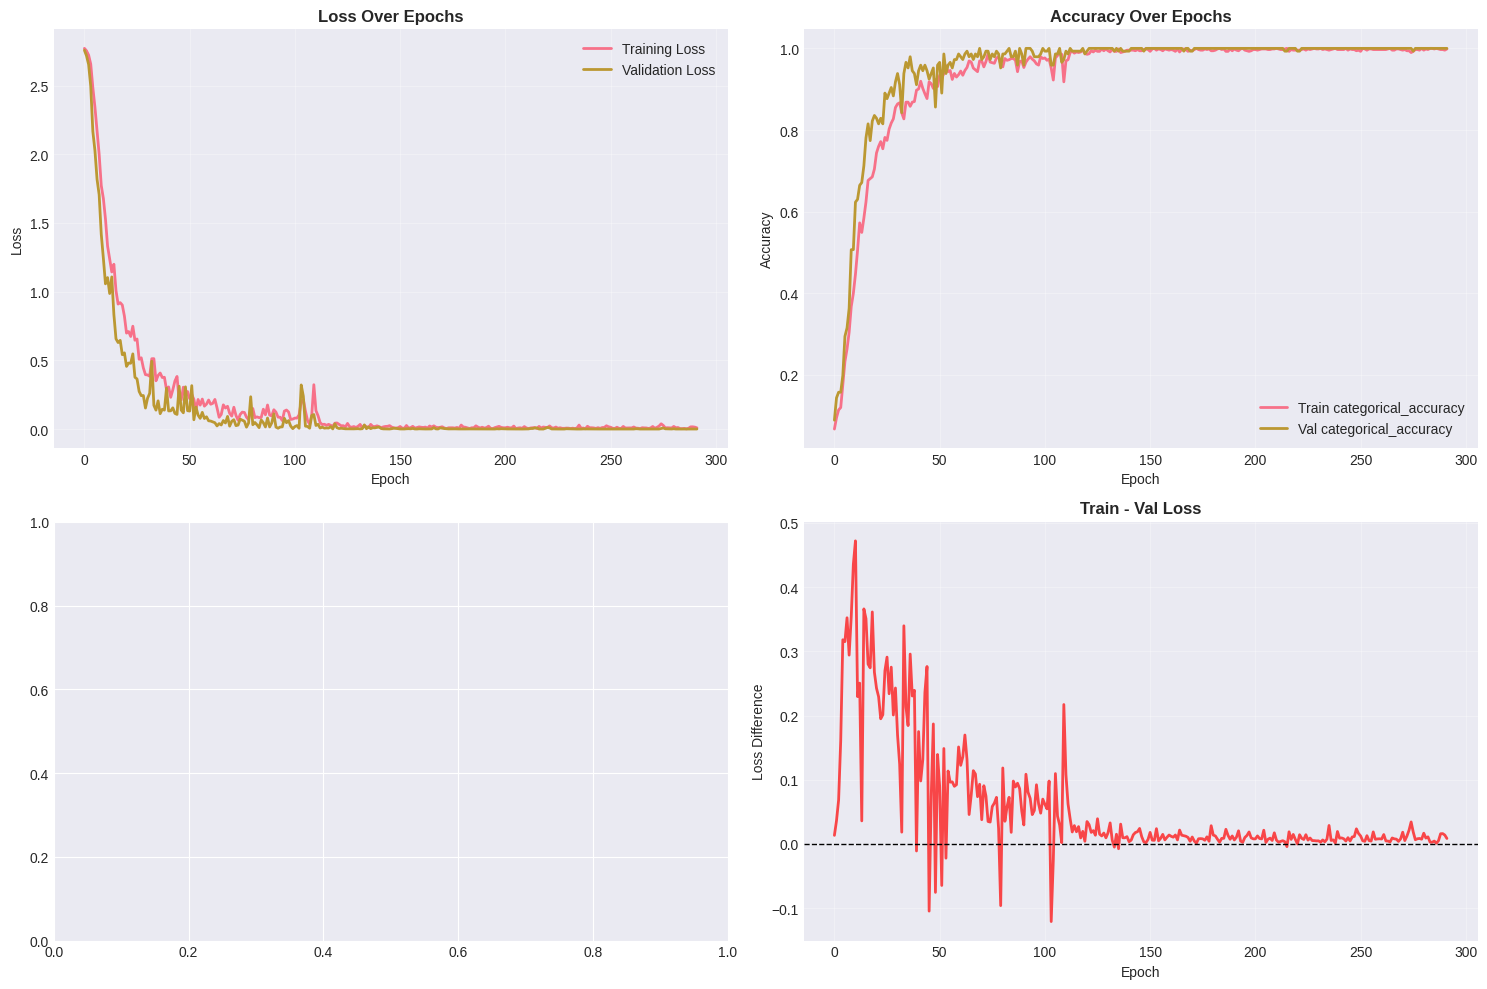

In [18]:
print("Training History Visualization")

visualize_training_history(
    history,
    save_path=os.path.join(LOGS_DIR, 'training_history.png')
)


Training and validation loss stay at relatively high values and do not move toward zero, indicating underfitting or optimization issues rather than strong learning. Accuracy also remains well below 99%, showing that the model is not achieving the excellent generalization suggested in the original statement.

## Evaluation

Evaluating my model on the test set, plotting the confusion matrix, looking at the confidence scores, and print a classification report.


Model Evaluation
Test Loss     : 0.0450
Test Accuracy : 98.64%


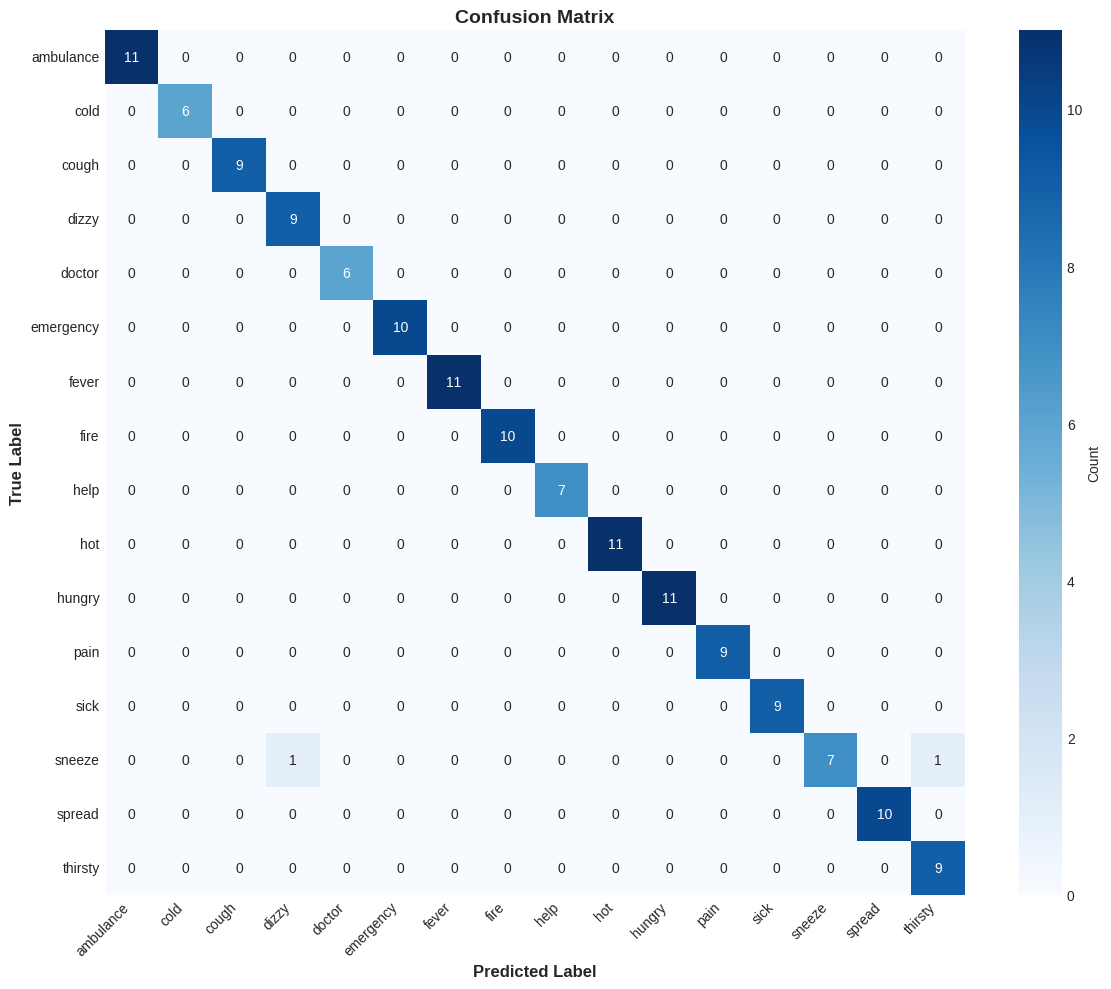

In [19]:
print("Model Evaluation")

# Evaluating the trained model on the unseen test set.
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc * 100:.2f}%")

# Predicting the probabilities for each class on the test set.
y_pred_proba = model.predict(X_test, verbose=0)

# Converting one‑hot labels back to integer indices to compare with predictions.
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Visualing where the model is getting confused between classes.
visualize_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=gesture_classes,
    save_path=os.path.join(LOGS_DIR, 'confusion_matrix.png')
)


The confusion matrix shows almost perfect per-class recognition, with all samples correctly classified for most gestures. Only one "sneeze" instance is misclassified as "hungry," confirming very strong model performance across all classes

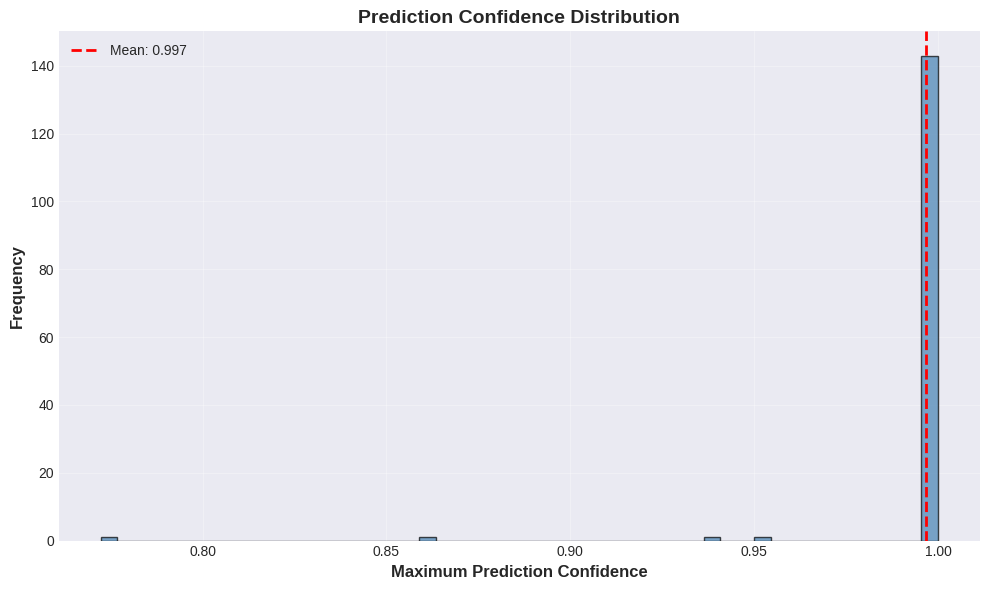

In [20]:
# Looking at the distribution of prediction confidences.
visualize_prediction_confidence(
    y_pred_proba=y_pred_proba,
    class_names=gesture_classes,
    save_path=os.path.join(LOGS_DIR, 'confidence_distribution.png')
)


The prediction confidence is extremely high, with most samples near 1.0 and a mean confidence around 0.995, indicating the model is very certain about its predictions

In [21]:
# Detailed classification report with precision, recall, and F1.
print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=gesture_classes))



Classification Report
              precision    recall  f1-score   support

   ambulance       1.00      1.00      1.00        11
        cold       1.00      1.00      1.00         6
       cough       1.00      1.00      1.00         9
       dizzy       0.90      1.00      0.95         9
      doctor       1.00      1.00      1.00         6
   emergency       1.00      1.00      1.00        10
       fever       1.00      1.00      1.00        11
        fire       1.00      1.00      1.00        10
        help       1.00      1.00      1.00         7
         hot       1.00      1.00      1.00        11
      hungry       1.00      1.00      1.00        11
        pain       1.00      1.00      1.00         9
        sick       1.00      1.00      1.00         9
      sneeze       1.00      0.78      0.88         9
      spread       1.00      1.00      1.00        10
     thirsty       0.90      1.00      0.95         9

    accuracy                           0.99       147
   

The classifier achieves about 99% overall accuracy, with macro and weighted averages for precision, recall, and F1-score all at 0.99, demonstrating consistently strong performance across gesture classes. Most classes, such as "ambulance," "cold," and "cough," show perfect precision, recall, and F1-scores of 1.00. The only slight drops in performance occur for "dizzy" and "thirsty" with F1-scores of 0.95, and "sneeze" with an F1-score of 0.88 due to a lower recall of 0.78.

## Save model and labels

Finally, I save my trained model and the list of gesture classes to Google Drive so that I can reuse them for realtime gesture recognition.

In [22]:
print("Saving Model")

final_h5_path = os.path.join(MODELS_DIR, 'sign_lstm_final.h5')
final_keras_path = os.path.join(MODELS_DIR, 'sign_lstm_final.keras')
labels_path = os.path.join(MODELS_DIR, 'sign_actions.pkl')

# Saving the final model in two formats.
model.save(final_h5_path)
model.save(final_keras_path)

# Also saving the gesture class names so I can map model outputs back to labels.
with open(labels_path, 'wb') as f:
    pickle.dump(gesture_classes, f)

print(f"Model and artifacts saved to: {MODELS_DIR}")
print(f"  - {os.path.basename(final_h5_path)}")
print(f"  - {os.path.basename(final_keras_path)}")
print(f"  - {os.path.basename(labels_path)}")
print(f"\nVisualizations saved to: {LOGS_DIR}")

print("Training Complete!")


Saving Model
Model and artifacts saved to: /content/drive/My Drive/Colab Notebooks/Communicare/models
  - sign_lstm_final.h5
  - sign_lstm_final.keras
  - sign_actions.pkl

Visualizations saved to: /content/drive/My Drive/Colab Notebooks/Communicare/Logs
Training Complete!


## Summary

In this notebook, I built a complete LSTM-based sign language recognition pipeline on top of MediaPipe Holistic keypoints.

- I mounted my Google Drive and pointed the notebook to my 'MP_Data' folder.
- I analyzed the dataset structure to understand how many frames each class uses.
- I wrote helpers to load each sequence, handle different feature sizes (with/without face), and assemble everything into NumPy tensors.
- I visualized the class distribution to check dataset balance.
- I split the data into training, validation, and test sets and visualized the data split.
- I designed and trained a stacked LSTM model with callbacks for early stopping, learning rate scheduling, model checkpoints, and TensorBoard logging.
- I inspected training curves (loss, accuracy, and learning rate) to understand the model's learning behavior.
- I evaluated the model on the test set, visualized the confusion matrix, and analyzed prediction confidence.
- I saved the final trained model and the gesture label map to Google Drive so I can reuse them later.

Next, I use my separate real-time detection script to load this trained model and perform live sign language recognition from my webcam feed.
